In [1]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.75' 

%matplotlib widget
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import numpy as np
from skimage.restoration import unwrap_phase
from temgym_core.components import Detector
from temgym_core.utils import fibonacci_spiral
from temgym_core.gaussian import GaussianRayBeta
from temgym_core.gaussian_taylor import (
    AberratedLens, 
    FreeSpaceParaxial, 
    SigmoidAperture,
    evaluate_gaussian_packets_jax_scan
)

jax.config.update("jax_enable_x64", True)
import jax_dataclasses as jdc

Single Beam Case

In [ ]:
w0  = 4
f   = 100.0
C_sph   = 1.0e-6
C_coma_x = 1e-5
C_coma_y = 2e-4

wavelength = 0.25
num_rays = 1
rx, ry = 2, 0.0
lam = jnp.ones(num_rays)*wavelength
k0  = 2*jnp.pi/lam
C0 = jnp.ones(num_rays)*(1.0 + 0.0j)
eta = jnp.full((num_rays,2), 0.0+0.0j)
scale = -1j * (2.0 / (k0 * w0**2))
Qinv0 = scale[..., None, None] * jnp.eye(2, dtype=jnp.complex128)

ray_in = GaussianRayBeta(x=rx, 
                         y=ry, 
                         dx=0.0, 
                         dy=0.0, 
                         z=0.0, 
                         pathlength=0.0,
                         Q_inv=Qinv0, 
                         eta=eta, 
                         C=C0, 
                         k0=k0)

ray_in=ray_in.to_vector()

lens = AberratedLens(z=0.0, focal_length=f, C_sph=C_sph, C_coma_x=C_coma_x, C_coma_y=C_coma_y)
ray_out = lens.__call__(ray_in)

W = 60
Nx = Ny = 256
dx = W/Nx
dy = W/Ny
grid = Detector(z=lens.z + 0.0, pixel_size=(dx, dy), shape=(Nx, Ny))
coords = grid.coords
X, Y = coords[:,0].reshape(grid.shape), coords[:,1].reshape(grid.shape)
x, y = X[0,:], Y[:,0]

rxy_img = jnp.stack([jnp.asarray(X), jnp.asarray(Y)], axis=-1)
phi_exact = np.exp(1j * k0 * jnp.real(lens.complex_action(rxy_img)))

# Single beam
x0 = float(np.ravel(rx)[0]); 
y0 = float(np.ravel(ry)[0])
E_in = jnp.exp(-(((X - x0)**2 + (Y - y0)**2) / w0**2))
E_exact =  phi_exact * E_in

E_gaussian = evaluate_gaussian_packets_jax_scan(ray_out, grid, batch_size=1)

TypeError: GaussianRayBeta.__init__() got an unexpected keyword argument 'k0'

: 

In [52]:
amp_exact = np.abs(E_exact); amp_exact /= amp_exact.max()

phase_exact = np.angle(E_exact)
phase_local = np.angle(E_gaussian)
phase_diff = np.angle(np.exp(1j*(np.abs(phase_exact) - np.abs(phase_local))))
phase_exact_unwrapped = unwrap_phase(phase_exact)
phase_local_unwrapped = unwrap_phase(phase_local)

# Convert unwrapped phases to optical path length (OPL)
opl_exact_unwrapped = phase_exact_unwrapped / ray_out.k0
opl_local_unwrapped = phase_local_unwrapped / ray_out.k0

# Pick a reference point near the beam center (x0,y0) and align both OPLs there.
# This removes the arbitrary constant offset between the two OPL maps.
ix0 = np.argmin(np.abs(x - rx))
iy0 = np.argmin(np.abs(y - ry))

ref_exact = opl_exact_unwrapped[iy0, ix0]
ref_local = opl_local_unwrapped[iy0, ix0]

opl_exact_unwrapped = opl_exact_unwrapped - ref_exact
opl_local_unwrapped = opl_local_unwrapped - ref_local

# Keep wrapped/unwrapped phase variables consistent (if needed downstream)
phase_exact_unwrapped = opl_exact_unwrapped * ray_out.k0
phase_local_unwrapped  = opl_local_unwrapped * ray_out.k0

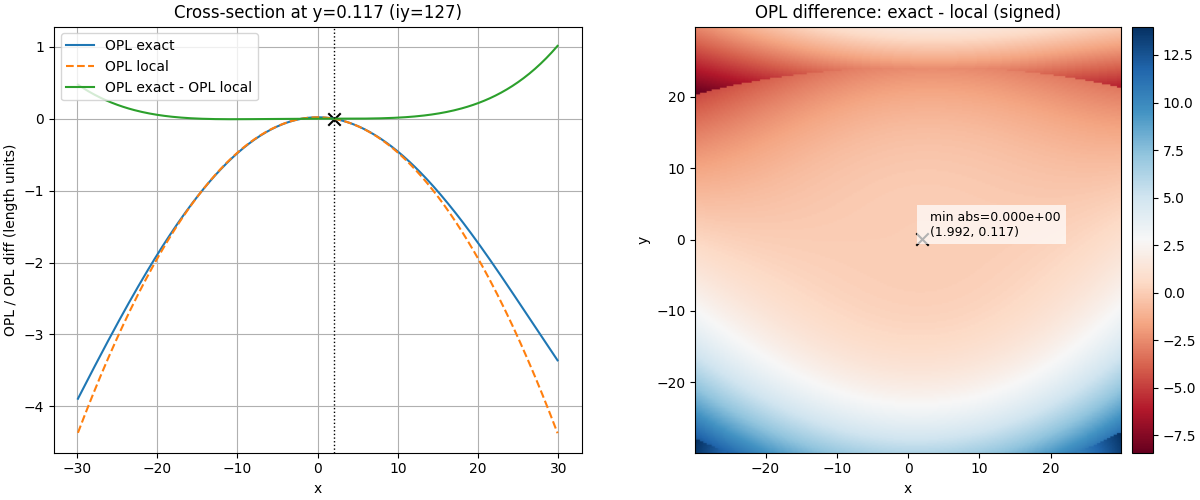

: 

In [ ]:
extent = [x.min(), x.max(), y.min(), y.max()]

diff_opl = opl_exact_unwrapped - opl_local_unwrapped
diff_abs = np.abs(diff_opl)
iy_min, ix_min = np.unravel_index(np.argmin(diff_abs), diff_abs.shape)
x_min = float(x[ix_min]); y_min = float(y[iy_min])
min_val = float(diff_abs[iy_min, ix_min])

iy = int(np.argmin(np.abs(y - ry)))
opl_diff_cross = diff_opl[iy, :]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

ax = axes[0]
ax.plot(x, opl_exact_unwrapped[iy, :], label='OPL exact', color='C0')
ax.plot(x, opl_local_unwrapped[iy, :], label='OPL local', linestyle='--', color='C1')
ax.plot(x, opl_diff_cross, label='OPL exact - OPL local', color='C2')
# mark global-min (vertical line + marker at cross-section value)
ax.axvline(x=x_min, color='k', linestyle=':', linewidth=1)
val_at_xmin = float(np.interp(x_min, x, opl_diff_cross))
ax.scatter([x_min], [val_at_xmin], c='k', marker='x', s=80)
ax.set_title(f'Cross-section at y={y[iy]:.3f} (iy={iy})')
ax.set_xlabel('x'); ax.set_ylabel('OPL / OPL diff (length units)')
ax.grid(True)
ax.legend(loc='upper left')

# 2) Signed OPL difference (exact - local)
ax = axes[1]
cmap = 'RdBu'
im2 = ax.imshow(diff_opl, origin='lower', extent=extent, aspect='equal', cmap=cmap)
ax.set_title('OPL difference: exact - local (signed)')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.scatter(x_min, y_min, c='k', marker='x', s=80)
ax.text(x_min, y_min, f'  min abs={min_val:.3e}\n  ({x_min:.3f}, {y_min:.3f})',
    color='k', fontsize=9, verticalalignment='bottom', horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.02)

plt.show()


n_beams case

In [ ]:
w0  = 0.25
f   = 100.0
C_sph   = 1.0e-6
C_coma_x = 1e-5
C_coma_y = 2e-4
W = 60
wavelength = 0.25

radius = W / 2 * np.sqrt(2)
num_rays = 50000
rx, ry = fibonacci_spiral(num_rays, radius=radius)

mask = (np.abs(rx) <= W/2  + W / 5 ) & (np.abs(ry) <= W/2 + W / 5  )
rx = rx[mask]
ry = ry[mask]
num_rays = len(rx)

lam = jnp.ones(num_rays)*wavelength
k0  = 2*jnp.pi/lam
C0 = jnp.ones(num_rays)*(1.0 + 0.0j)
eta = jnp.full((num_rays,2), 0.0+0.0j)
scale = -1j * (2.0 / (k0 * w0**2))
Qinv0 = scale[..., None, None] * jnp.eye(2, dtype=jnp.complex128)

ray_in = GaussianRayBeta(x=rx, 
                       y=ry, 
                       dx=0.0, 
                       dy=0.0, 
                       z=0.0, 
                       pathlength=0.0,
                       Q_inv=Qinv0, 
                       eta=eta, 
                       C=C0, 
                       k0=k0)
ray_in=ray_in.to_vector()

lens = AberratedLens(z=0.0, focal_length=f, C_sph=C_sph, C_coma_x=C_coma_x, C_coma_y=C_coma_y)
ray_out = lens.__call__(ray_in)

Nx = Ny = 256
dx = W/Nx
dy = W/Ny
grid = Detector(z=lens.z + 0.0, pixel_size=(dx, dy), shape=(Nx, Ny))
coords = grid.coords
X, Y = coords[:,0].reshape(grid.shape), coords[:,1].reshape(grid.shape)
x, y = X[0,:], Y[:,0]

In [ ]:
E_local = evaluate_gaussian_packets_jax_scan(ray_in, grid, batch_size=100)

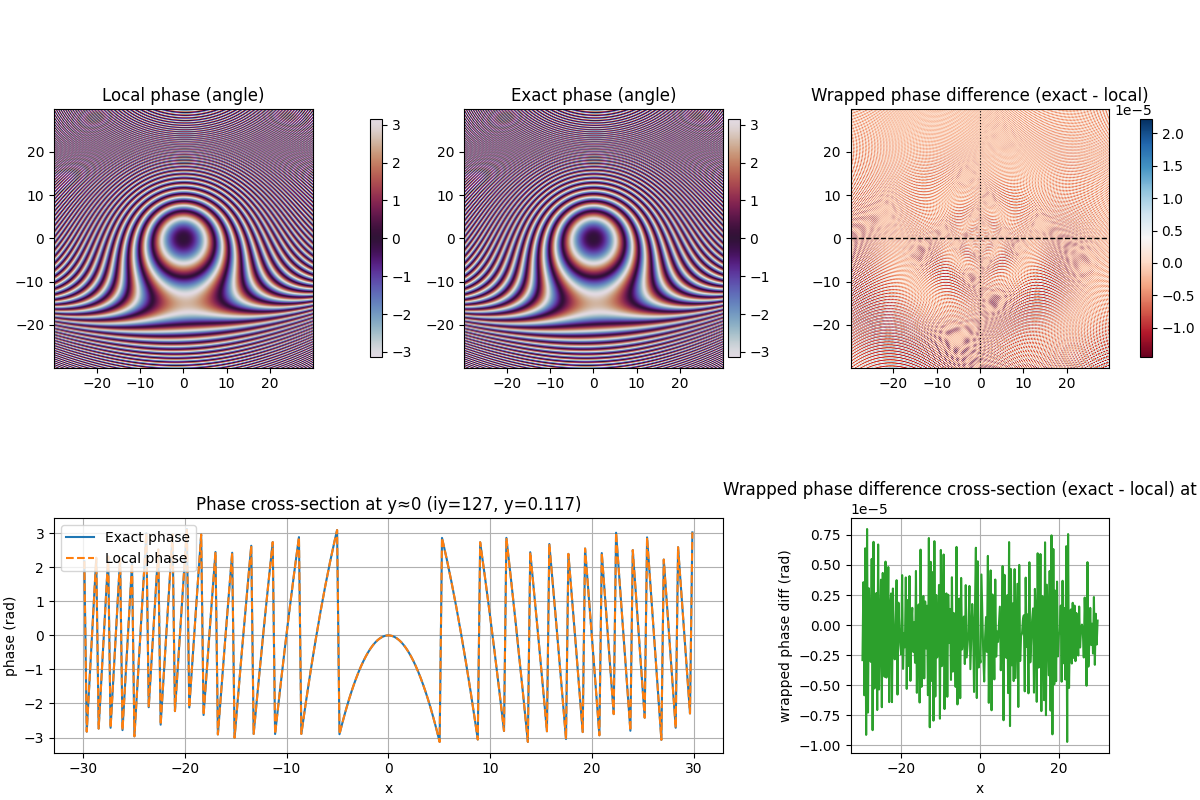

In [29]:
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 0.5], width_ratios=[1, 1, 1])

# Top row: three main plots in a row
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Bottom row: cross-sections (left spans two cols, right in the last col)
ax4 = fig.add_subplot(gs[1, :2])
ax5 = fig.add_subplot(gs[1, 2])

# Ensure numpy arrays for matplotlib
ang_local = np.angle(np.asarray(E_local))
ang_exact = np.angle(np.asarray(phi_exact))
x_np = np.asarray(x)
y_np = np.asarray(y)

# 1) local phase
im1 = ax1.imshow(ang_local, origin='lower', extent=extent, aspect='equal', cmap='twilight')
ax1.set_title('Local phase (angle)')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)

# 2) exact phase
im2 = ax2.imshow(ang_exact, origin='lower', extent=extent, aspect='equal', cmap='twilight')
ax2.set_title('Exact phase (angle)')
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)

# 3) Wrapped phase difference (large view)
diff = np.angle(np.exp(1j * (ang_exact - ang_local)))
im3 = ax3.imshow(diff, origin='lower', extent=extent, aspect='equal', cmap='RdBu')
ax3.set_title('Wrapped phase difference (exact - local)')
ax3.axhline(0.0, color='k', linestyle='--', linewidth=1)
ax3.axvline(0.0, color='k', linestyle=':', linewidth=0.8)
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.02)

# Find row index nearest y=0 for cross-section
iy0 = int(np.argmin(np.abs(y_np - 0.0)))

# Cross-sections (y ~ 0)
ang_local_cs = ang_local[iy0, :]
ang_exact_cs = ang_exact[iy0, :]
diff_cs = diff[iy0, :]

# 4) Phase cross-section at y=0 (spanning left two columns)
ax4.plot(x_np, ang_exact_cs, label='Exact phase', color='C0')
ax4.plot(x_np, ang_local_cs, label='Local phase', linestyle='--', color='C1')
ax4.set_title(f'Phase cross-section at y≈0 (iy={iy0}, y={y_np[iy0]:.3f})')
ax4.set_xlabel('x'); ax4.set_ylabel('phase (rad)')
ax4.grid(True); ax4.legend(loc='upper left')

# 5) Wrapped phase-difference cross-section at y=0 (right column)
ax5.plot(x_np, diff_cs, color='C2')
ax5.set_title('Wrapped phase difference cross-section (exact - local) at y≈0')
ax5.set_xlabel('x'); ax5.set_ylabel('wrapped phase diff (rad)')
ax5.grid(True)


plt.show()

In [30]:
aperture = SigmoidAperture(radius=W/4, sharpness=10000, z=0.0)
free_space = FreeSpaceParaxial(distance=200.0, z=aperture.z)
components = [aperture, free_space]


ray0 = ray0.derive(x=ray0.x, y=ray0.y)
gp2 = run_to_end(ray0, components)

In [31]:
E_input_after_aperture = evaluate_gaussian_packets_jax_scan(aperture(ray0), grid, batch_size=2000)
E_local = evaluate_gaussian_packets_jax_scan(gp2, grid, batch_size=2000)

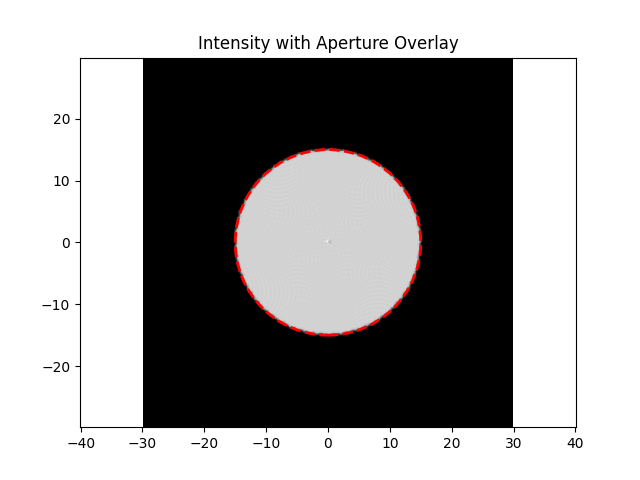

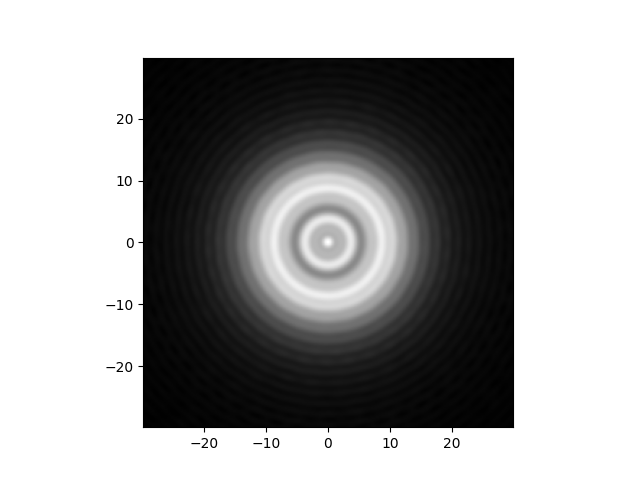

In [32]:

plt.figure()
plt.title('Intensity with Aperture Overlay')
plt.axis('equal')
circle = plt.Circle((0, 0), aperture.radius, color='red', fill=False, linestyle='--', linewidth=2)
plt.gca().add_artist(circle)
plt.imshow(np.abs(E_input_after_aperture), cmap='gray', extent=extent)

# Plot the aperture radius on top of the intensity image
plt.figure()
plt.imshow(np.abs(E_local), cmap='gray', extent=extent)


